In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
tf.__version__

'0.10.0rc0'

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot = True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
data.test.labels[0:5, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [5]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [6]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

In [7]:
img_size = 28

img_size_flat = img_size * img_size

img_shape = (img_size, img_size)

num_classes = 10

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

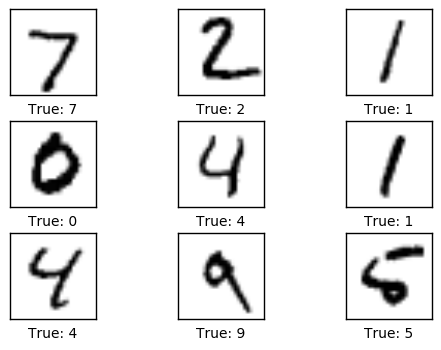

In [9]:
images = data.test.images[0:9]

cls_true = data.test.cls[0:9]

plot_images(images = images, cls_true=cls_true)


TensorFlow Graph

The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

TensorFlow can also take advantage of multi-core CPUs as well as GPUs - and Google has even built special chips just for TensorFlow which are called TPUs (Tensor Processing Units) and are even faster than GPUs.

A TensorFlow graph consists of the following parts which will be detailed below:

    Placeholder variables used to change the input to the graph.
    Model variables that are going to be optimized so as to make the model perform better.
    The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
    A cost measure that can be used to guide the optimization of the variables.
    An optimization method which updates the variables of the model.

In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard, which is not covered in this tutorial.


In [10]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])


Variables to be optimized

Apart from the placeholder variables that were defined above and which serve as feeding input data into the model, there are also some model variables that must be changed by TensorFlow so as to make the model perform better on the training data.

The first variable that must be optimized is called weights and is defined here as a TensorFlow variable that must be initialized with zeros and whose shape is [img_size_flat, num_classes], so it is a 2-dimensional tensor (or matrix) with img_size_flat rows and num_classes columns.


In [12]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))


Model

This simple mathematical model multiplies the images in the placeholder variable x with the weights and then adds the biases.

The result is a matrix of shape [num_images, num_classes] because x has shape [num_images, img_size_flat] and weights has shape [img_size_flat, num_classes], so the multiplication of those two matrices is a matrix with shape [num_images, num_classes] and then the biases vector is added to each row of that matrix.

Note that the name logits is typical TensorFlow terminology, but other people may call the variable something else.

In [15]:
logits = tf.matmul(x, weights) + biases

In [16]:
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension = 1)


Cost-function to be optimized

To make the model better at classifying the input images, we must somehow change the variables for weights and biases. To do this we first need to know how well the model currently performs by comparing the predicted output of the model y_pred to the desired output y_true.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the weights and biases of the model.

TensorFlow has a built-in function for calculating the cross-entropy. Note that it uses the values of the logits because it also calculates the softmax internally.

In [17]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = y_true)

In [18]:
cost = tf.reduce_mean(cross_entropy)

In [19]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(cost)

In [20]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [21]:
session = tf.Session()

In [25]:
session.run(tf.initialize_all_variables())

In [26]:
batch_size = 100

In [27]:
def optimize(num_iterations):
    for i in range(num_iterations):
        
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        
        session.run(optimizer, feed_dict = feed_dict_train)

In [28]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))
    
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')



def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

In [29]:
print_accuracy()

Accuracy on test-set: 9.8%


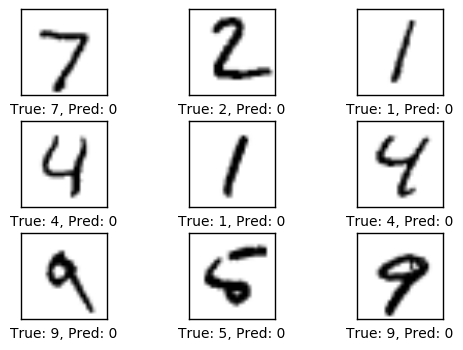

In [30]:
plot_example_errors()

In [32]:
optimize(num_iterations = 1)

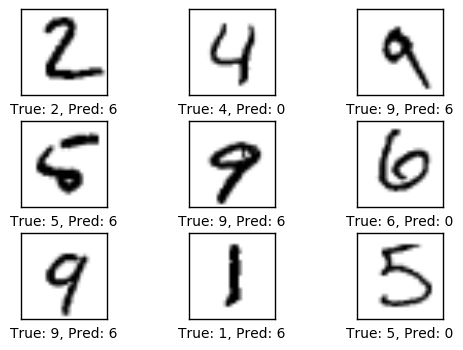

In [33]:
plot_example_errors()

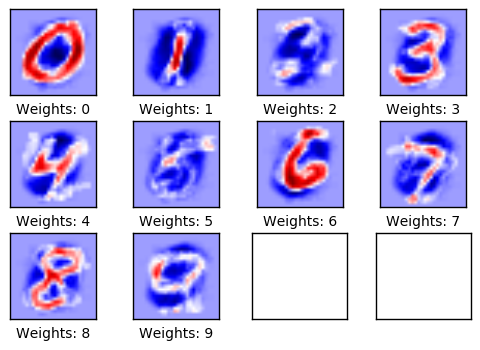

In [34]:
plot_weights()

In [35]:
optimize(num_iterations = 9)
print_accuracy()

Accuracy on test-set: 78.2%


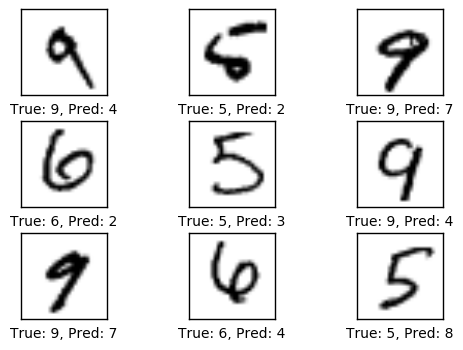

In [36]:
plot_example_errors()

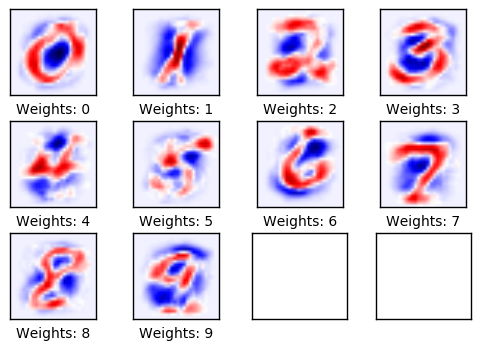

In [37]:
plot_weights()

Accuracy on test-set: 92.1%


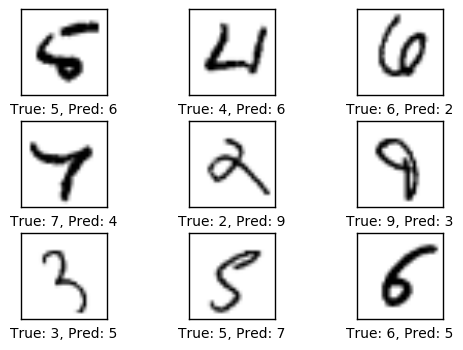

In [38]:
optimize(num_iterations = 990)
print_accuracy()
plot_example_errors()

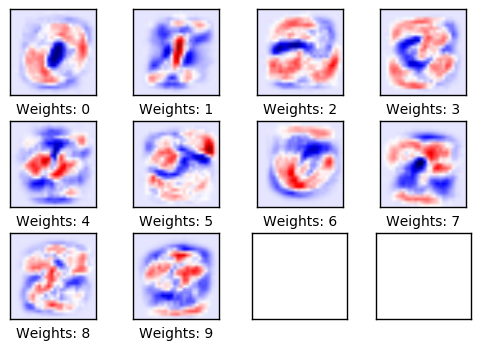

In [39]:
plot_weights()

[[ 947    0    5    4    0    4   11    3    6    0]
 [   0 1106    3    2    0    2    4    2   16    0]
 [   4    4  948   15    7    2   12    9   22    9]
 [   0    0   24  940    0   12    3    8   16    7]
 [   1    2    5    2  889    0   14    2   13   54]
 [   9    3   12   70    9  718   15    9   40    7]
 [   6    3    7    2    9    9  916    1    5    0]
 [   1    9   28    7    6    0    0  939    2   36]
 [   3    7   10   33    8   16   10   10  873    4]
 [   8    7    2   12   16    4    0   16   13  931]]


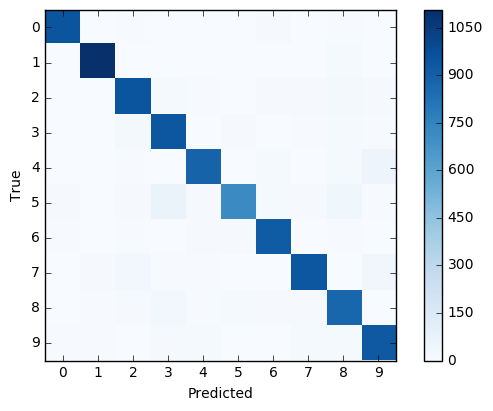

In [40]:
print_confusion_matrix()

In [41]:
session.close()